In [2]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import time
import concurrent.futures

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn import model as modellib
from mrcnn.model import log
from mrcnn.config import Config


import skimage
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Root directory of the project
ROOT_DIR = '/home/sky8/cal/'

img_train = os.path.join(ROOT_DIR, 'train', 'images') 
img_val = os.path.join(ROOT_DIR, 'validation', 'images') 

mask_train = os.path.join(ROOT_DIR, 'train', 'masks') 
mask_val = os.path.join(ROOT_DIR, 'validation', 'masks') 


train_imglist = os.listdir(img_train)
val_imglist = os.listdir(img_val)

train_count = len(train_imglist)
val_count = len(val_imglist)
# width = 1280
# height = 800
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
# COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

/home/sky8/calcification/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
class CalConfig(Config):
    """Configuration for training on the nucleus segmentation dataset."""
    # Give the configuration a recognizable name
    NAME = "calcification"

    # Adjust depending on your GPU memory
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + nucleus

    # Number of training and validation steps per epoch
    STEPS_PER_EPOCH = (750 - 20) // IMAGES_PER_GPU
    VALIDATION_STEPS = max(1, 20 // IMAGES_PER_GPU)

    # Don't exclude based on confidence. Since we have two classes
    # then 0.5 is the minimum anyway as it picks between nucleus and BG
    DETECTION_MIN_CONFIDENCE = 0

    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    BACKBONE = "resnet50"

    # Input image resizing
    # Random crops of size 512x512
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    IMAGE_MIN_SCALE = 2.0

    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)

    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 1000
    POST_NMS_ROIS_INFERENCE = 2000

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.9

    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 64

    # Image mean (RGB)
    MEAN_PIXEL = np.array([43.53, 39.56, 48.22])

    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask

    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 128

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 200

    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 400
    
config = CalConfig()
config.display()   
 



Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               200
MEAN_PIXEL                     [43.53 39.56 48.22]
MINI_MASK_SHAPE                (56, 56)
NAME                           calcification
NUM_CLASSES                    2
POOL_SIZE                      7
PO

In [4]:
class CalDataset(utils.Dataset):
    """Create customized dataset class to load data"""
    def load_cal(self,count, data_dir, mask_dir, namelist):
        """load """
        
        #Add classes
        self.add_class("breast", 1, "calcification" )
        
        #Add images
        
        for i in range(count):
            src = namelist[i]
            
            name = src.split('_')
            full_name = '_'.join(name[0:4])
            mask_middle= full_name.split('.')[0]
            mask_name = mask_middle + '_MASK.jpg'
            mask_path = os.path.join(mask_dir, mask_name)
            
            self.add_image("breast", image_id = i, path = os.path.join(data_dir, full_name), mask_path = mask_path , full_name =full_name)
#     def load_image(self, image_id):
#         """load image from local path"""
        
#         info = self.image_info[image_id]
       
#         image = skimage.io.imread(info.path)
        
#         return image
        
    def load_mask(self, image_id):
        """load the mask image"""
        
        info = self.image_info[image_id]
        
       
        mask = skimage.io.imread(info['mask_path']).astype(bool)
        mask = mask[:,:,np.newaxis]
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index("calcification")])
        
        return mask, class_ids.astype(np.int32)
        
    def load_name(self, image_id):
        """load the image name"""
        info = self.image_info[image_id]
        
        return info['full_name']
        

In [5]:
# Training dataset
dataset = CalDataset()
dataset.load_cal(200, img_train, mask_train, train_imglist)
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 200
Class Count: 2
  0. BG                                                
  1. calcification                                     


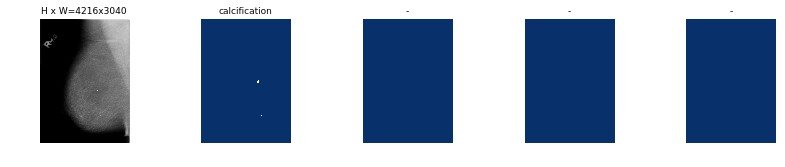

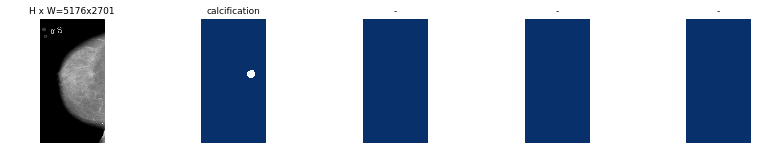

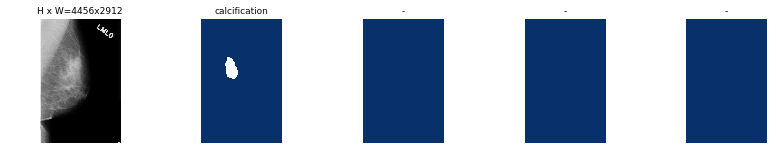

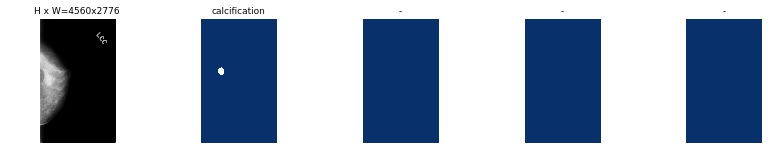

In [13]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

image_id  150 
image                    shape: (4632, 3016, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (4632, 3016, 1)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min: 1632.00000  max: 2904.00000  int32


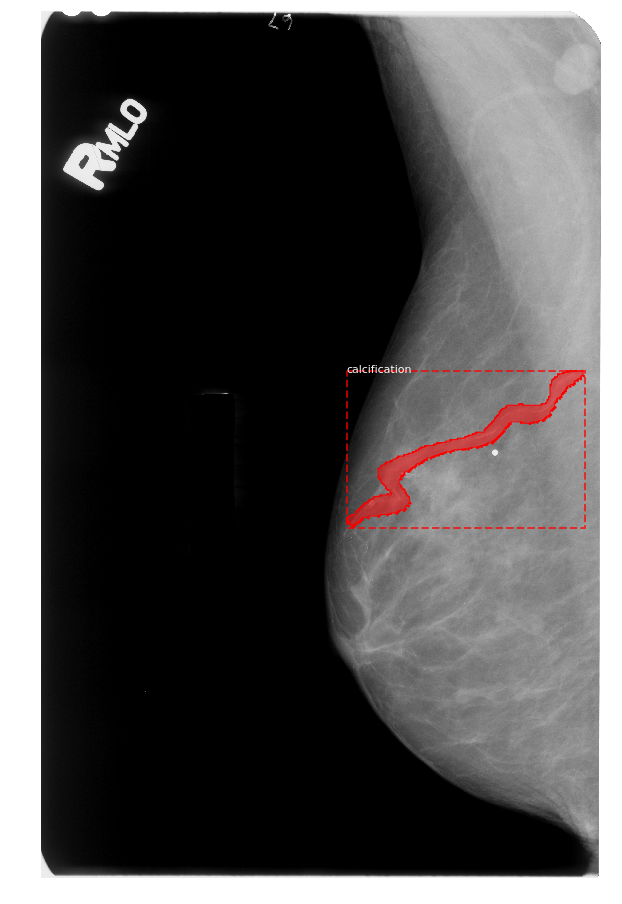

In [14]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [6]:
def image_stats(image_id):
    """Returns a dict of stats for one image."""
    image = dataset.load_image(image_id)
    mask, _ = dataset.load_mask(image_id)
    bbox = utils.extract_bboxes(mask)
    # Sanity check
    assert mask.shape[:2] == image.shape[:2]
    # Return stats dict
    return {
        "id": image_id,
        "shape": list(image.shape),
        "bbox": [[b[2] - b[0], b[3] - b[1]]
                 for b in bbox
                 # Uncomment to exclude nuclei with 1 pixel width
                 # or height (often on edges)
                 # if b[2] - b[0] > 1 and b[3] - b[1] > 1
                ],
        "color": np.mean(image, axis=(0, 1)),
    }

# Loop through the dataset and compute stats over multiple threads
# This might take a few minutes
t_start = time.time()
with concurrent.futures.ThreadPoolExecutor() as e:
    stats = list(e.map(image_stats, dataset.image_ids))
t_total = time.time() - t_start
print("Total time: {:.1f} seconds".format(t_total))

Total time: 205.0 seconds


Image Count:  200
Height  mean: 5156.73  median: 4780.00  min: 4006.00  max: 7111.00
Width   mean: 3119.95  median: 3043.00  min: 1846.00  max: 4876.00
Color   mean (RGB): 48.12 48.12 48.12


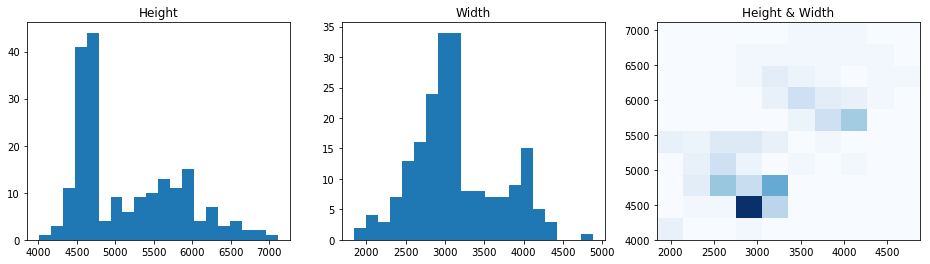

In [7]:
# Image stats
image_shape = np.array([s['shape'] for s in stats])
image_color = np.array([s['color'] for s in stats])
print("Image Count: ", image_shape.shape[0])
print("Height  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(image_shape[:, 0]), np.median(image_shape[:, 0]),
    np.min(image_shape[:, 0]), np.max(image_shape[:, 0])))
print("Width   mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(image_shape[:, 1]), np.median(image_shape[:, 1]),
    np.min(image_shape[:, 1]), np.max(image_shape[:, 1])))
print("Color   mean (RGB): {:.2f} {:.2f} {:.2f}".format(*np.mean(image_color, axis=0)))

# Histograms
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].set_title("Height")
_ = ax[0].hist(image_shape[:, 0], bins=20)
ax[1].set_title("Width")
_ = ax[1].hist(image_shape[:, 1], bins=20)
ax[2].set_title("Height & Width")
_ = ax[2].hist2d(image_shape[:, 1], image_shape[:, 0], bins=10, cmap="Blues")

Nuclei/Image
Image area <= 4000**2:  mean: 1.0  median: 1.0  min: 1.0  max: 1.0
Image area <= 5000**2:  mean: 1.0  median: 1.0  min: 1.0  max: 1.0
Image area <= 6000**2:  mean: 1.0  median: 1.0  min: 1.0  max: 1.0


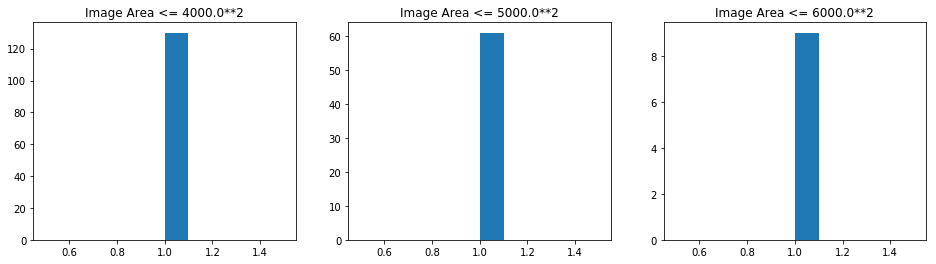

In [11]:
# Segment by image area
image_area_bins = [4000**2, 5000**2, 6000**2]

print("Nuclei/Image")
fig, ax = plt.subplots(1, len(image_area_bins), figsize=(16, 4))
area_threshold = 0
for i, image_area in enumerate(image_area_bins):
    nuclei_per_image = np.array([len(s['bbox']) 
                                 for s in stats 
                                 if area_threshold < (s['shape'][0] * s['shape'][1]) <= image_area])
    area_threshold = image_area
    if len(nuclei_per_image) == 0:
        print("Image area <= {:4}**2: None".format(np.sqrt(image_area)))
        continue
    print("Image area <= {:4.0f}**2:  mean: {:.1f}  median: {:.1f}  min: {:.1f}  max: {:.1f}".format(
        np.sqrt(image_area), nuclei_per_image.mean(), np.median(nuclei_per_image), 
        nuclei_per_image.min(), nuclei_per_image.max()))
    ax[i].set_title("Image Area <= {:4}**2".format(np.sqrt(image_area)))
    _ = ax[i].hist(nuclei_per_image, bins=10)


Image Area <= 4000**2
  Total Nuclei:  130
  Nucleus Height. mean: 603.20  median: 384.00  min: 88.00  max: 3008.00
  Nucleus Width.  mean: 525.11  median: 396.00  min: 72.00  max: 1840.00
  Nucleus Area.   mean: 469715.69  median: 167136.00  min: 6336.00  max: 5534720.00

Image Area <= 5000**2
  Total Nuclei:  61
  Nucleus Height. mean: 709.25  median: 416.00  min: 72.00  max: 3280.00
  Nucleus Width.  mean: 666.23  median: 416.00  min: 48.00  max: 2880.00
  Nucleus Area.   mean: 904437.51  median: 172800.00  min: 3456.00  max: 9446400.00

Image Area <= 6000**2
  Total Nuclei:  9
  Nucleus Height. mean: 286.22  median: 208.00  min: 104.00  max: 624.00
  Nucleus Width.  mean: 436.44  median: 320.00  min: 152.00  max: 1376.00
  Nucleus Area.   mean: 182513.78  median: 61568.00  min: 18240.00  max: 858624.00


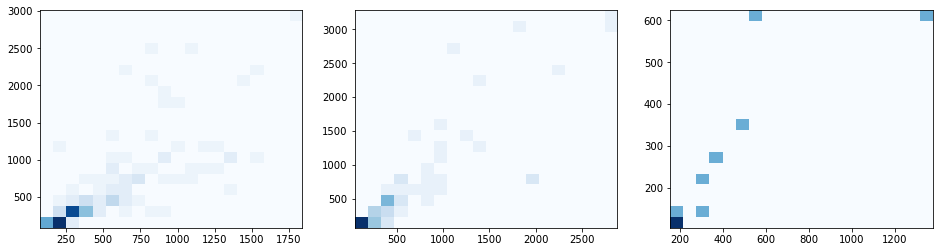

In [12]:
# Nuclei size stats
fig, ax = plt.subplots(1, len(image_area_bins), figsize=(16, 4))
area_threshold = 0
for i, image_area in enumerate(image_area_bins):
    nucleus_shape = np.array([
        b 
        for s in stats if area_threshold < (s['shape'][0] * s['shape'][1]) <= image_area
        for b in s['bbox']])
    nucleus_area = nucleus_shape[:, 0] * nucleus_shape[:, 1]
    area_threshold = image_area

    print("\nImage Area <= {:.0f}**2".format(np.sqrt(image_area)))
    print("  Total Nuclei: ", nucleus_shape.shape[0])
    print("  Nucleus Height. mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
        np.mean(nucleus_shape[:, 0]), np.median(nucleus_shape[:, 0]),
        np.min(nucleus_shape[:, 0]), np.max(nucleus_shape[:, 0])))
    print("  Nucleus Width.  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
        np.mean(nucleus_shape[:, 1]), np.median(nucleus_shape[:, 1]),
        np.min(nucleus_shape[:, 1]), np.max(nucleus_shape[:, 1])))
    print("  Nucleus Area.   mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
        np.mean(nucleus_area), np.median(nucleus_area),
        np.min(nucleus_area), np.max(nucleus_area)))

    # Show 2D histogram
    _ = ax[i].hist2d(nucleus_shape[:, 1], nucleus_shape[:, 0], bins=20, cmap="Blues")

Nucleus Aspect Ratio.  mean: 0.71  median: 0.70  min: 0.42  max: 1.09


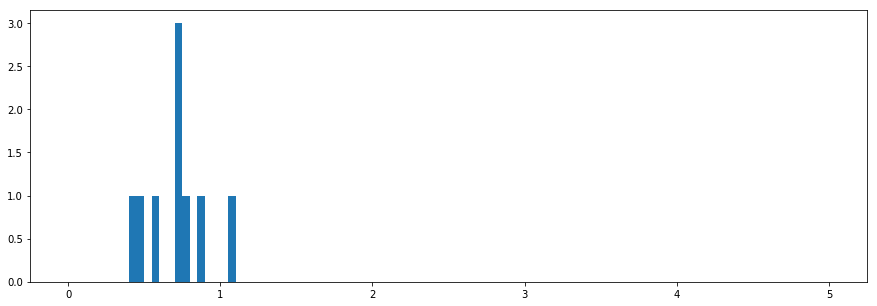

In [13]:
# Nuclei height/width ratio
nucleus_aspect_ratio = nucleus_shape[:, 0] / nucleus_shape[:, 1]
print("Nucleus Aspect Ratio.  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(nucleus_aspect_ratio), np.median(nucleus_aspect_ratio),
    np.min(nucleus_aspect_ratio), np.max(nucleus_aspect_ratio)))
plt.figure(figsize=(15, 5))
_ = plt.hist(nucleus_aspect_ratio, bins=100, range=[0, 5])

image_id:  10 
Original shape:  (4632, 3072, 3)
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:  223.00000  max:  425.00000  int32


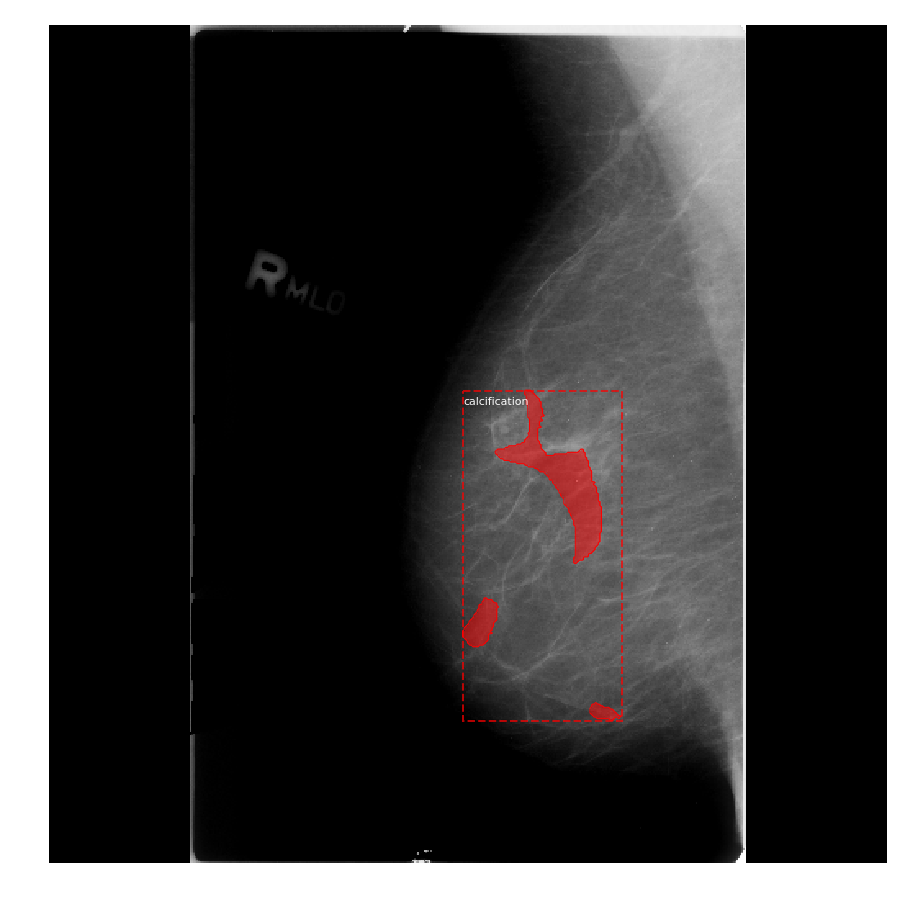

In [18]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [19]:
config.IMAGE_RESIZE_MODE

'square'

image                    shape: (512, 512, 3)         min:    0.00000  max:  253.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 4528.00000  float64
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:  151.00000  max:  335.00000  int32
mask                     shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool


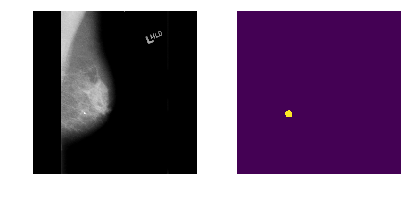

In [20]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

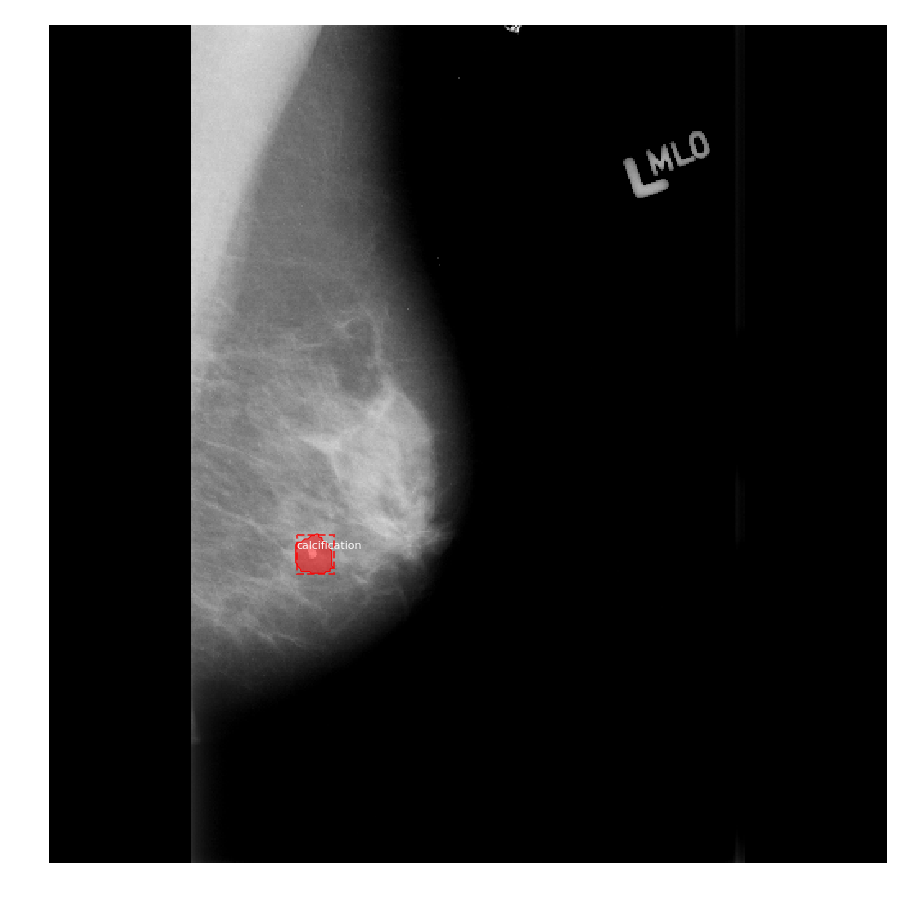

In [21]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

mask                     shape: (56, 56, 1)           min:    0.00000  max:    1.00000  bool


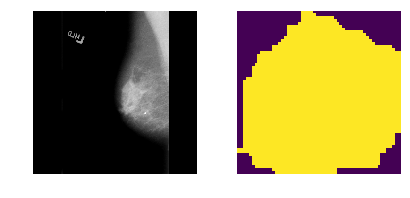

In [22]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

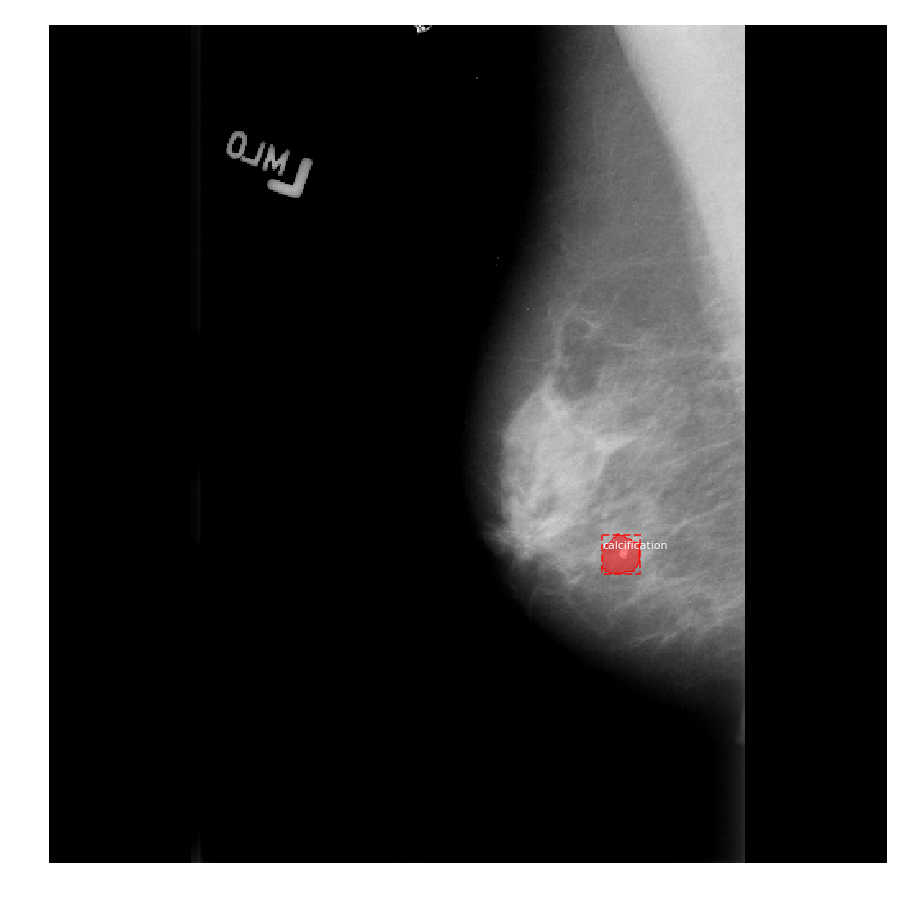

In [23]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

Count:  65472
Scales:  (32, 64, 128, 256, 512)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 49152
Anchors in Level 1: 12288
Anchors in Level 2: 3072
Anchors in Level 3: 768
Anchors in Level 4: 192
Level 0. Anchors:  49152  Feature map Shape: [128 128]
Level 1. Anchors:  12288  Feature map Shape: [64 64]
Level 2. Anchors:   3072  Feature map Shape: [32 32]
Level 3. Anchors:    768  Feature map Shape: [16 16]
Level 4. Anchors:    192  Feature map Shape: [8 8]


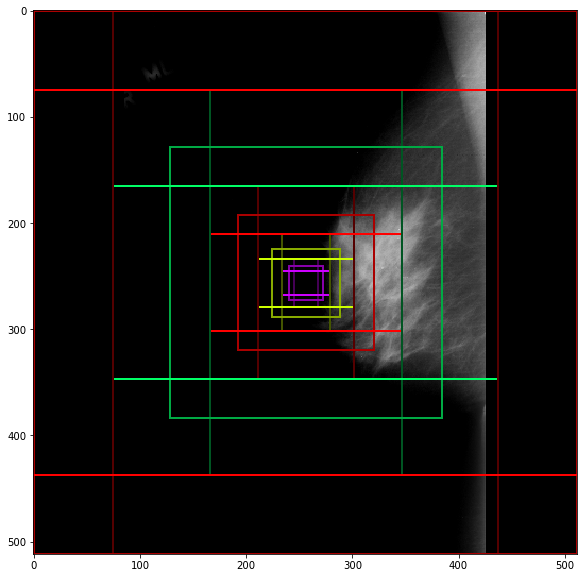

In [24]:
## Visualize anchors of one cell at the center of the feature map

# Load and display random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)

# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, image.shape)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

# Display
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


In [26]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  65472
Scales:  (32, 64, 128, 256, 512)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 49152
Anchors in Level 1: 12288
Anchors in Level 2: 3072
Anchors in Level 3: 768
Anchors in Level 4: 192


Level 0. Anchors:  49152  Feature map Shape: [128 128]
Level 1. Anchors:  12288  Feature map Shape: [64 64]
Level 2. Anchors:   3072  Feature map Shape: [32 32]
Level 3. Anchors:    768  Feature map Shape: [16 16]
Level 4. Anchors:    192  Feature map Shape: [8 8]


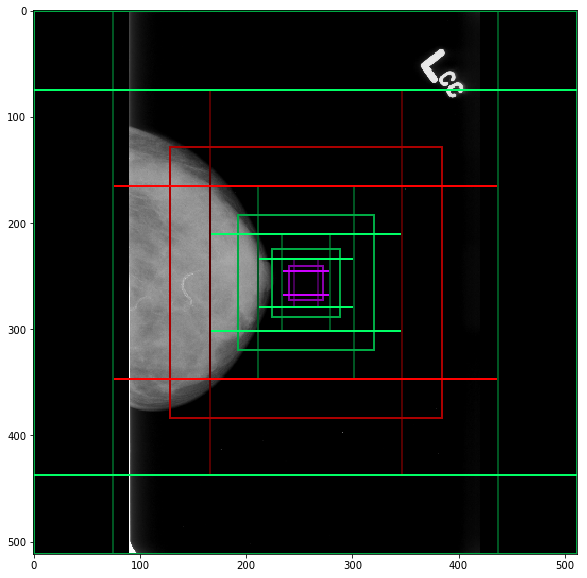

In [28]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


In [30]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [33]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (4, 128, 4)           min:    1.00000  max:  510.00000  int32
mrcnn_class_ids          shape: (4, 128, 1)           min:    0.00000  max:    1.00000  int32
mrcnn_bbox               shape: (4, 128, 2, 4)        min:   -3.71429  max:    3.85965  float32
mrcnn_mask               shape: (4, 128, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (4, 200)              min:    0.00000  max:    1.00000  int32
gt_boxes                 shape: (4, 200, 4)           min:    0.00000  max:  392.00000  int32
gt_masks                 shape: (4, 56, 56, 200)      min:    0.00000  max:    1.00000  bool
rpn_match                shape: (4, 65472, 1)         min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (4, 64, 4)            min:   -2.35002  max:    1.40625  float64
image_id:  105 


anchors                  shape: (65472, 4)            min: -362.03867  max:  810.03867  float64
refined_anchors          shape: (2, 4)                min:   96.00000  max:  263.00000  float32
Positive anchors: 2
Negative anchors: 62
Neutral anchors: 65408
BG                     : 94
calcification          : 34


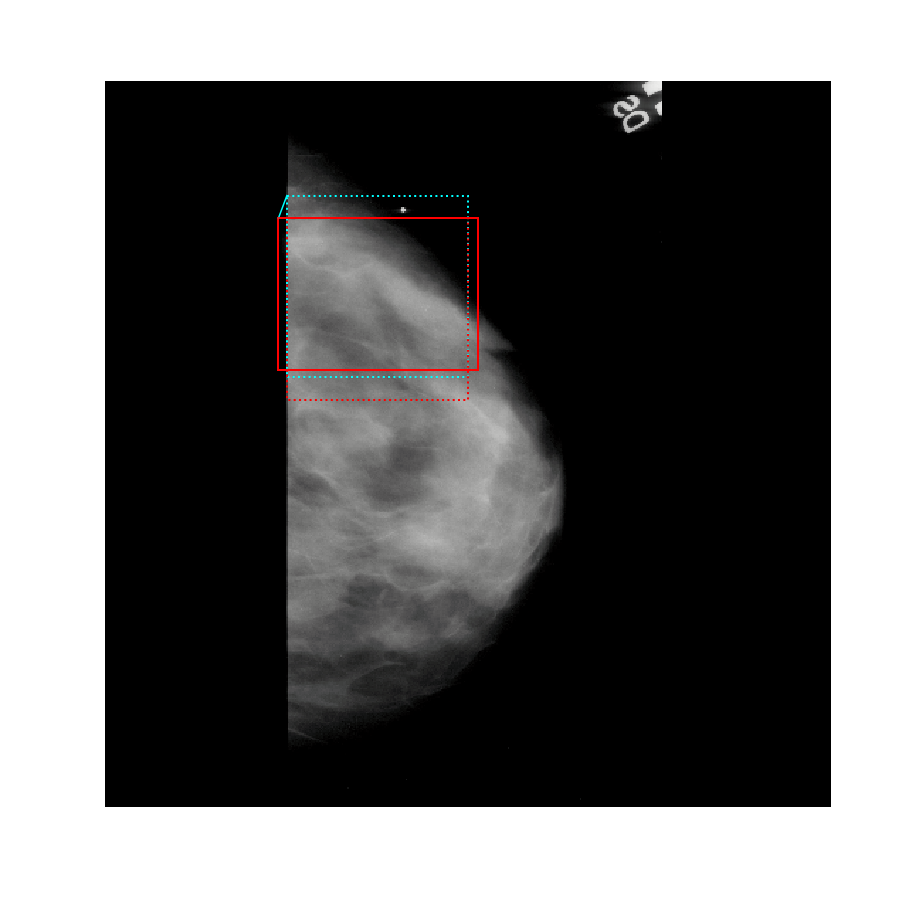

In [34]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors, ax=ax)

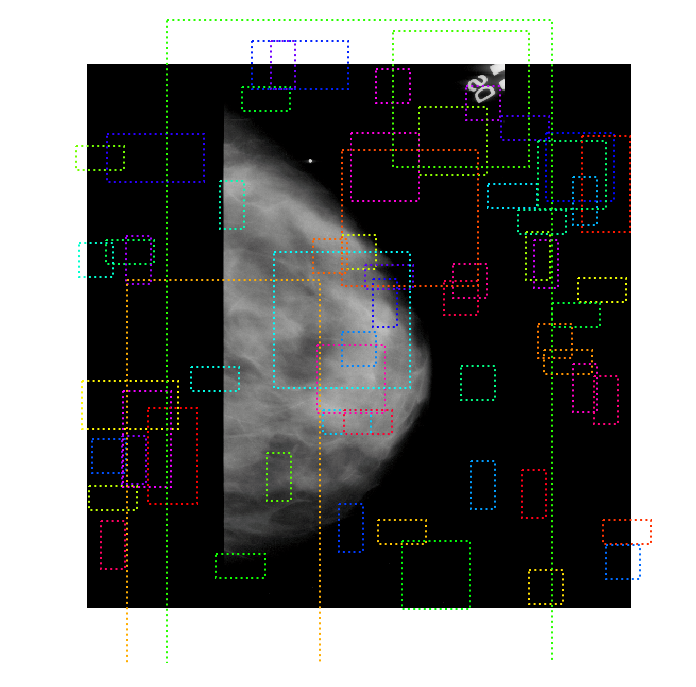

In [35]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

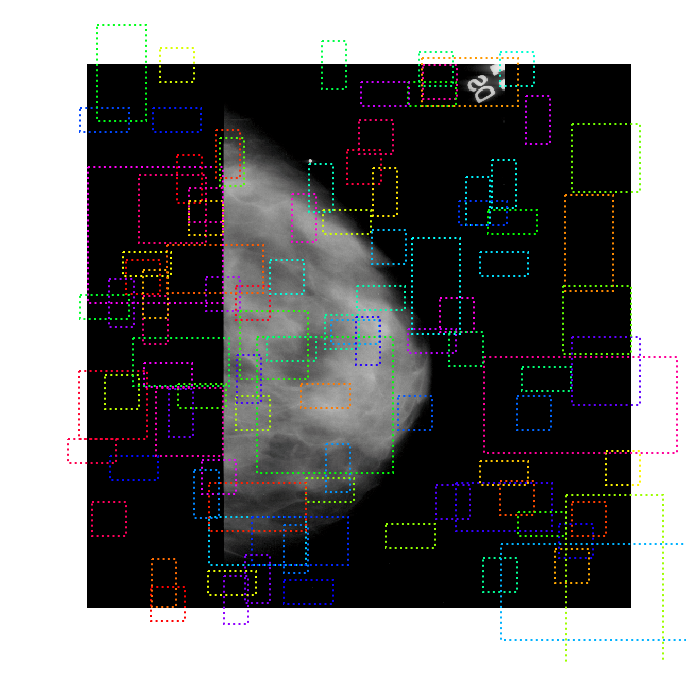

In [36]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

## ROIS

Positive ROIs:  34
Negative ROIs:  94
Positive Ratio: 0.27
Unique ROIs: 128 out of 128


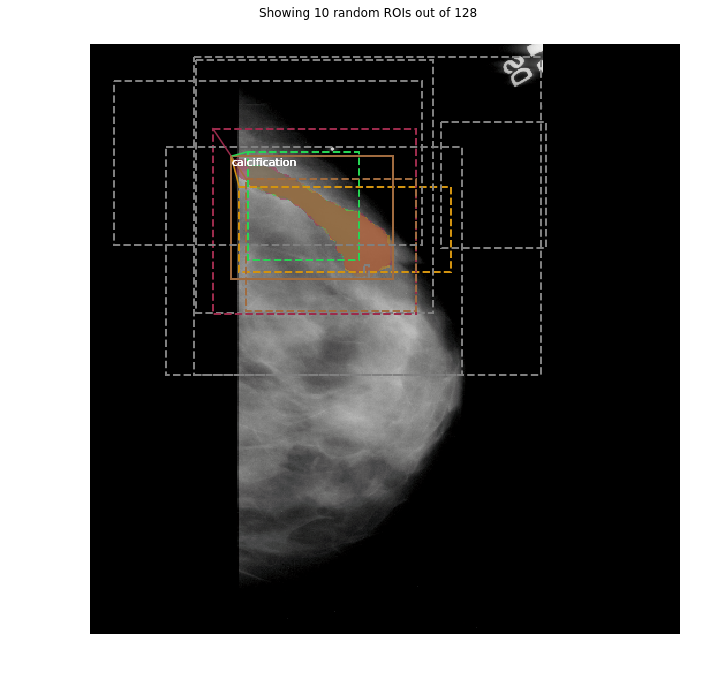

In [37]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

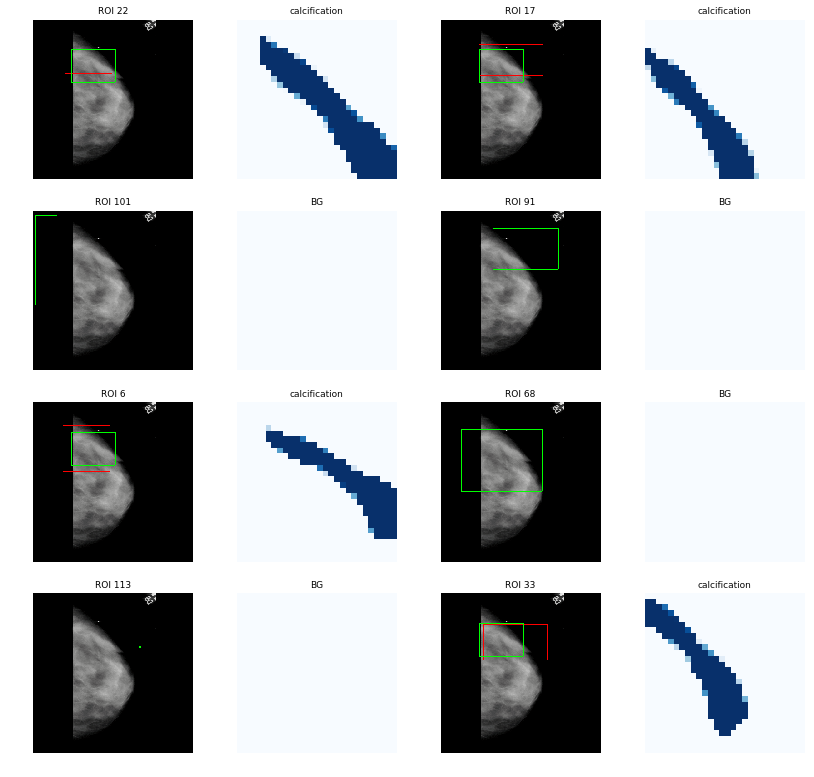

In [38]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [39]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   42  0.33
   42  0.33
   42  0.33
   42  0.33
   42  0.33
   42  0.33
   42  0.33
   42  0.33
   42  0.33
   42  0.33
Average percent: 0.33
